# Sheet 6

## 1 Autoencoders: theory and practice

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


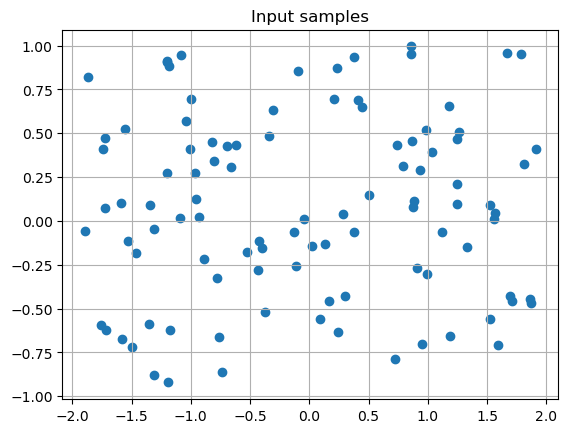

In [20]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# create 100 uniform samples from a rectangle [-2, 2] x [-1, 1]
num_samples = 100
data = torch.zeros(num_samples, 2)
data[:, 0] = torch.rand(num_samples) * 4 - 2
data[:, 1] = torch.rand(num_samples) * 2 - 1

# plot the samples
plt.scatter(data[:, 0], data[:, 1])
plt.title("Input samples")
plt.grid(True)
plt.show()

In [21]:
from torch.utils.data import DataLoader, TensorDataset

# Prepare data loader
dataset = TensorDataset(data, data)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True, drop_last=True)

# get batched data from the data loader
x, y = next(iter(data_loader))
print("x.shape:", x.shape)
print("y.shape:", y.shape)
print("all x == y:", torch.all(x == y).item())

x.shape: torch.Size([8, 2])
y.shape: torch.Size([8, 2])
all x == y: True


## (a)

In [22]:
# TODO: define the Autoencoder architecture

import torch
from torch import nn
import pytorch_lightning as pl

class Autoencoder(nn.Module):
    def __init__(self, hidded_channels, latent_dim=1, input_dim=2,activation=nn.ReLU,PCA=False):
        super().__init__()

        if not PCA:
            # TODO: implement the encoder and decoder
            layers_encoder = []
            layers_decoder = []
            n_layers = len(hidded_channels)

            layers_encoder.append(nn.Linear(input_dim,hidded_channels[0])) # adding input layer
            #layers_encoder.append(input_dim)
            layers_encoder.append(activation())
            pass_latent = False
            for i, (l_in,l_out) in enumerate(zip(hidded_channels[:-1],hidded_channels[1:])):      
                if pass_latent:
                    layers_decoder.append(nn.Linear(l_in,l_out))
                    if i != n_layers-2: # no relu activation of output?
                        layers_decoder.append(activation())
                else:
                    if l_out == latent_dim: # maybe we also need to ommit the activation func in the latent layer?
                        pass_latent = True
                    layers_encoder.append(nn.Linear(l_in,l_out))
                    layers_encoder.append(activation())

            self.encoder = nn.Sequential(*layers_encoder)
            self.decoder = nn.Sequential(*layers_decoder)
        else: 
            # Linear encoder
            self.encoder = nn.Linear(input_dim, latent_dim)
            # Linear decoder
            self.decoder = nn.Linear(latent_dim, input_dim)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x):
        x_encoded = self.encoder(x)
        return x_encoded
    
    def decode(self, x):
        x_decoded = self.decoder(x)
        return x_decoded

"""
            #self.encoder = nn.ModuleList(layers_encoder)
            #self.decoder = nn.ModuleList(layers_decoder)
# when using the nn.ModuleList one must define the forward pass explicitly as in understood, example with loop like:
        # def forward(self, x):
        #     for layer in self.encoder:
        #         x = layer(x)
        #     for layer in self.decoder:
        #         x = layer(x)
        #     return x

"""

class AutoencoderModule(pl.LightningModule):
    def __init__(self, **model_kwargs):
        super().__init__()
        self.autoencoder = Autoencoder(**model_kwargs)
        self.loss_curve = []

    def forward(self, x):
        return self.autoencoder(x)

    def configure_optimizers(self):
        # as default use Adam optimizer:
        optimizer = torch.optim.Adam(self.parameters(), weight_decay=1e-4)

        return optimizer
    
    def on_train_start(self):
        self.loss_curve = []
        return super().on_train_start()

    def training_step(self, batch):
        x, _ = batch
        x_hat = self.autoencoder(x)
        loss = nn.MSELoss()(x_hat, x)
        self.loss_curve.append(loss.item())
        return loss


        

# FOR ELIAS AND OLIVER

Using ReLU activation bc i found online that or sigmoid is mainly used in autoencoders, but code is flexible so we can easily change it, i didnt know exactly what they meant with the point (iii) in 1 a so i added PCA like autoencoder. Autoencoders are reffered to as a generalization of PCA and I chat said like this is how a autoencoder i PCA like, but from what was said in the lectures i thought it was different but didnt find in the notes. But wikipedia says: 

 "If linear activations are used, or only a single sigmoid hidden layer, then the optimal solution to an autoencoder is strongly related to principal component analysis (PCA). The weights of an autoencoder with a single hidden layer of size p (where p
is less than the size of the input) span the same vector subspace as the one spanned by the first p
 principal components, and the output of the autoencoder is an orthogonal projection onto this subspace."
 
   so thoght maybe it is meant like this. added it with a PCA=Flase in the Autoencode class, so it would work with the hand out code of the AutoencoderModule class. 

In [23]:
hidded_channels_small = [20, 10, 1, 10, 20, 2]
autoencoder_module_small = AutoencoderModule(hidded_channels=hidded_channels_small,latent_dim=1, input_dim=2, activation=nn.ReLU) #Autoencoder(hidded_channels_small)#  # TODO: specify the model here
print("small Model overview:", autoencoder_module_small)

hidded_channels_big = [50, 50, 50, 1, 50, 50, 50, 2]
autoencoder_module_big = AutoencoderModule(hidded_channels=hidded_channels_big,latent_dim=1, input_dim=2, activation=nn.ReLU ) 
print("big Model overview:", autoencoder_module_big)

PCA_autoencoder = AutoencoderModule(hidded_channels=None,PCA=True,latent_dim=1, input_dim=2) 
print("pca like Model overview:", PCA_autoencoder)

small Model overview: AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=10, bias=True)
      (3): ReLU()
      (4): Linear(in_features=10, out_features=1, bias=True)
      (5): ReLU()
    )
    (decoder): Sequential(
      (0): Linear(in_features=1, out_features=10, bias=True)
      (1): ReLU()
      (2): Linear(in_features=10, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=2, bias=True)
    )
  )
)
big Model overview: AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): ReLU()
      (6): Linear(in_features=50, out_features=1, bias=True)
   

### They set 1000 max epochs but that takes hundred yrs to run so put 10 or 10 for looking quick

## (b)

In [24]:
# start the training using a PyTorch Lightning Trainer
trainer_small = pl.Trainer(max_epochs=1000, enable_checkpointing=False) # was max_epochs=1000 (1000 for test)

trainer_small.fit(autoencoder_module_small, data_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 563    | train
----------------------------------------------------
563       Trainable params
0         Non-trainable params
563       Total params
0.002     Total estimated model params size (MB)


Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


In [25]:
# start the training using a PyTorch Lightning Trainer
trainer_big = pl.Trainer(max_epochs=1000, enable_checkpointing=False)

trainer_big.fit(autoencoder_module_big, data_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 10.6 K | train
----------------------------------------------------
10.6 K    Trainable params
0         Non-trainable params
10.6 K    Total params
0.042     Total estimated model params size (MB)


Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


In [26]:
# start the training using a PyTorch Lightning Trainer
PCA_trainer = pl.Trainer(max_epochs=1000, enable_checkpointing=False)

PCA_trainer.fit(PCA_autoencoder, data_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 7      | train
----------------------------------------------------
7         Trainable params
0         Non-trainable params
7         Total params
0.000     Total estimated model params size (MB)


Training: |                                               | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

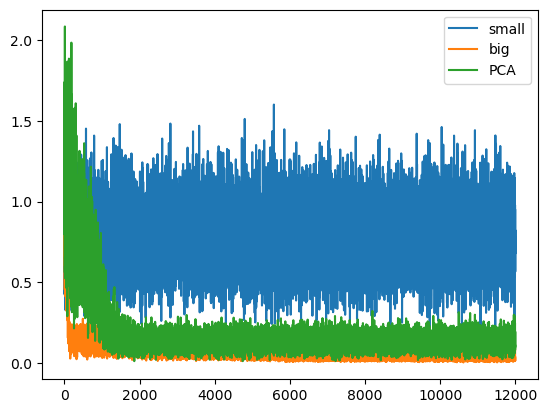

In [28]:
# len(autoencoder_module_big.loss_curve)
## here im not completely sure what i should actually plot, probably average over each epoch makes more sense, 
# i dont understand why the loss_curve length is so long.
plt.plot(range(len(autoencoder_module_small.loss_curve)),autoencoder_module_small.loss_curve,label="small")
plt.plot(range(len(autoencoder_module_big.loss_curve)),autoencoder_module_big.loss_curve,label="big")
plt.plot(range(len(PCA_autoencoder.loss_curve)),PCA_autoencoder.loss_curve,label="PCA")
plt.legend()

i now added weight regularization because the big model was overfitting. now its looking better

hmmm, not great looking idk

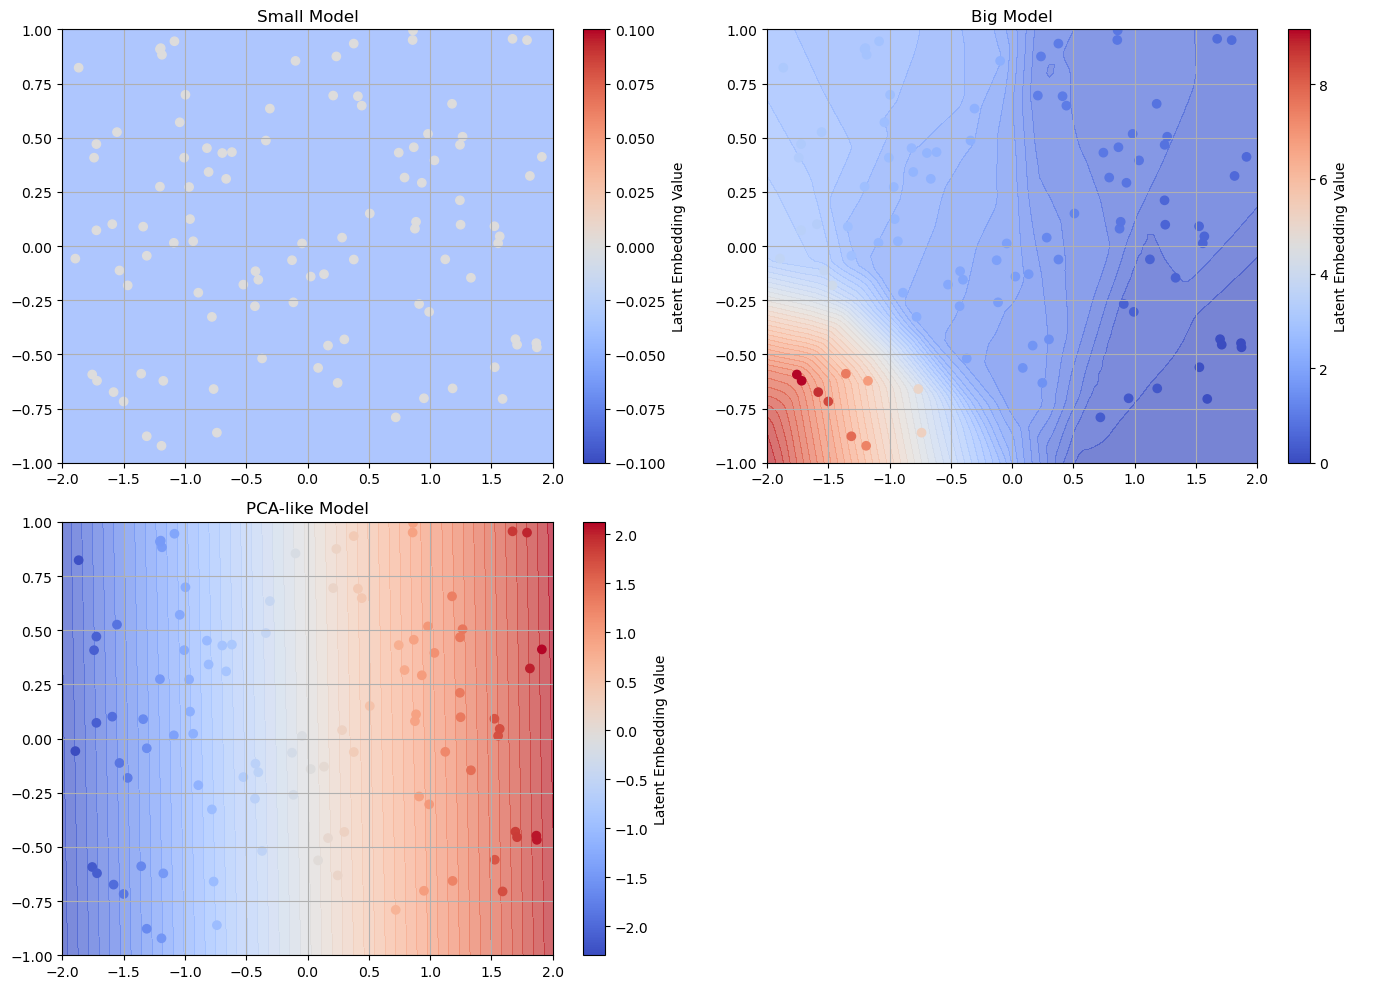

In [29]:
latent_embedding_small = autoencoder_module_small.autoencoder.encode(data)
latent_embedding_big = autoencoder_module_big.autoencoder.encode(data)
latent_embedding_PCA = PCA_autoencoder.autoencoder.encode(data)

# Flatten the grid for encoding
x_grid, y_grid = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-1, 1, 100))
# Convert grid to PyTorch tensors
x_tensor = torch.from_numpy(x_grid).float()  # Shape: (100, 100)
y_tensor = torch.from_numpy(y_grid).float()  # Shape: (100, 100)

# Step 2: Combine x and y into a grid tensor for encoding
grid = torch.stack((x_tensor, y_tensor), dim=-1)

grid_flat = grid.view(-1, 2)  # Flatten to shape (10000, 2)

# Encode the grid points using the autoencoders
contour_values1 = autoencoder_module_small.autoencoder.encode(grid_flat)
contour_values2 = autoencoder_module_big.autoencoder.encode(grid_flat)
contour_values3 = PCA_autoencoder.autoencoder.encode(grid_flat)

# Reshape the encoded values back to a 2D grid for contourf
contour_values1 = contour_values1.view(100, 100).detach().numpy()
contour_values2 = contour_values2.view(100, 100).detach().numpy()
contour_values3 = contour_values3.view(100, 100).detach().numpy()

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Adjust figsize for better layout

# Plot latent embeddings for each model
contour1 = axes[0, 0].contourf(x_grid, y_grid, contour_values1, levels=50, cmap='coolwarm', alpha=0.7)
contour2 = axes[0, 1].contourf(x_grid, y_grid, contour_values2, levels=50, cmap='coolwarm', alpha=0.7)
contour3 = axes[1, 0].contourf(x_grid, y_grid, contour_values3, levels=50, cmap='coolwarm', alpha=0.7)

scatter1 = axes[0, 0].scatter(data[:, 0], data[:, 1], c=latent_embedding_small.detach().numpy(), cmap='coolwarm')
scatter2 = axes[0, 1].scatter(data[:, 0], data[:, 1], c=latent_embedding_big.detach().numpy(), cmap='coolwarm')
scatter3 = axes[1, 0].scatter(data[:, 0], data[:, 1], c=latent_embedding_PCA.detach().numpy(), cmap='coolwarm')

fig.colorbar(scatter1, ax=axes[0, 0], label="Latent Embedding Value")
fig.colorbar(scatter2, ax=axes[0, 1], label="Latent Embedding Value")
fig.colorbar(scatter3, ax=axes[1, 0], label="Latent Embedding Value")

axes[0, 0].set_title("Small Model")
axes[0, 1].set_title("Big Model")
axes[1, 0].set_title("PCA-like Model")
axes[0, 0].grid(True)
axes[0, 1].grid(True)
axes[1, 0].grid(True)

# Hide the empty subplot (bottom-right) as we only need 3 plots
axes[1, 1].axis('off')
plt.tight_layout()
plt.show()


Visualize the embeddings as colors in the input data space. Idk if this is what they want, how else visualising a 1D latent space, and see correspondance with data? 

## (c)

## also make a prediciton before looking at plots below

If we sample points from an interval in the latent space, the decoder can attempt to map them to a curve in the ambient/input space. Guess what these curves may look like: i) After random initialization of the MLP parameters, and ii) After training the respective architecture. 

### i) 
also a random scatter plot as out put.

### ii) 
random scatter plot, but maybe with some similarity to the random scattering of the trained data, maybe OOOORRRR maybe its a line following the color change seen above, so for small model curve from left to roght as we go 0 to 1 from latent space, and for big quite random, and for PCA from right to left.

I tihnk for this case its a random scatter plot skewed along the direction of biggest varience of the previously sampled data, since this is the dimension the PCA will project the data down to. 
For the PCA the dat awill stay on the projected axes probably, the bigger the model the more the spread from the original axis.

## (d)

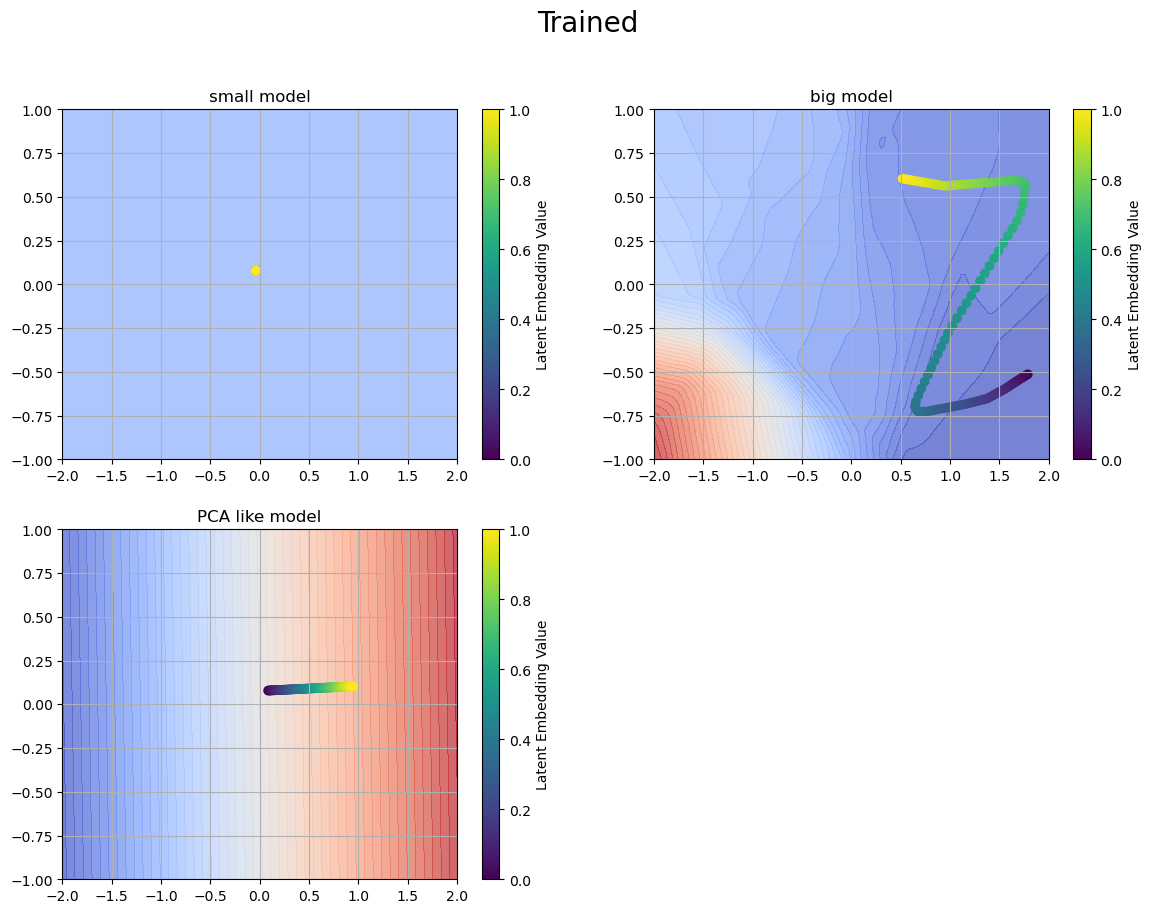

In [30]:
import numpy as np

latent_space_samples = np.linspace(0, 1, 100) # somewhat arbitrary choice for ReLu maybe, shoud just inlude origin
# if we change the non linearity to sigmoid, then from -1 to 1 i would say, 
# but also we need to think if we should have a non linearity in latent space
# for this random num task i dont see why not but idk
latent_space_samples = torch.tensor(latent_space_samples,dtype=torch.float32).view(100, 1)

# Encode the grid points using the autoencoders
contour_values1 = autoencoder_module_small.autoencoder.encode(grid_flat)
contour_values2 = autoencoder_module_big.autoencoder.encode(grid_flat)
contour_values3 = PCA_autoencoder.autoencoder.encode(grid_flat)

# Reshape the encoded values back to a 2D grid for contourf
contour_values1 = contour_values1.view(100, 100).detach().numpy()
contour_values2 = contour_values2.view(100, 100).detach().numpy()
contour_values3 = contour_values3.view(100, 100).detach().numpy()

samples_decoded_trained_small = autoencoder_module_small.autoencoder.decode(latent_space_samples)
samples_decoded_trained_big = autoencoder_module_big.autoencoder.decode(latent_space_samples)
samples_decoded_trained_PCA = PCA_autoencoder.autoencoder.decode(latent_space_samples)



fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Adjust figsize for better layout

# Plot latent embeddings for each model
contour1 = axes[0, 0].contourf(x_grid, y_grid, contour_values1, levels=50, cmap='coolwarm', alpha=0.7)
contour2 = axes[0, 1].contourf(x_grid, y_grid, contour_values2, levels=50, cmap='coolwarm', alpha=0.7)
contour3 = axes[1, 0].contourf(x_grid, y_grid, contour_values3, levels=50, cmap='coolwarm', alpha=0.7)

scatter1 = axes[0,0].scatter(samples_decoded_trained_small[:, 0].detach().numpy(), samples_decoded_trained_small[:, 1].detach().numpy(),c=latent_space_samples.detach().numpy(), cmap='viridis')
scatter2 = axes[0,1].scatter(samples_decoded_trained_big[:, 0].detach().numpy(), samples_decoded_trained_big[:, 1].detach().numpy(),c=latent_space_samples.detach().numpy(), cmap='viridis')
scatter3 = axes[1,0].scatter(samples_decoded_trained_PCA[:, 0].detach().numpy(), samples_decoded_trained_PCA[:, 1].detach().numpy(),c=latent_space_samples.detach().numpy(), cmap='viridis')

fig.colorbar(scatter1, ax=axes[0, 0], label="Latent Embedding Value")
fig.colorbar(scatter2, ax=axes[0, 1], label="Latent Embedding Value")
fig.colorbar(scatter3, ax=axes[1, 0], label="Latent Embedding Value")

axes[0,0].set_title("small model")
axes[0,1].set_title("big model")
axes[1,0].set_title("PCA like model")

axes[0,0].grid(True)
axes[0,1].grid(True)
axes[1,0].grid(True)

fig.suptitle('Trained',fontsize=20)
# Hide the empty subplot (bottom-right) as we only need 3 plots
axes[1, 1].axis('off')
plt.show()

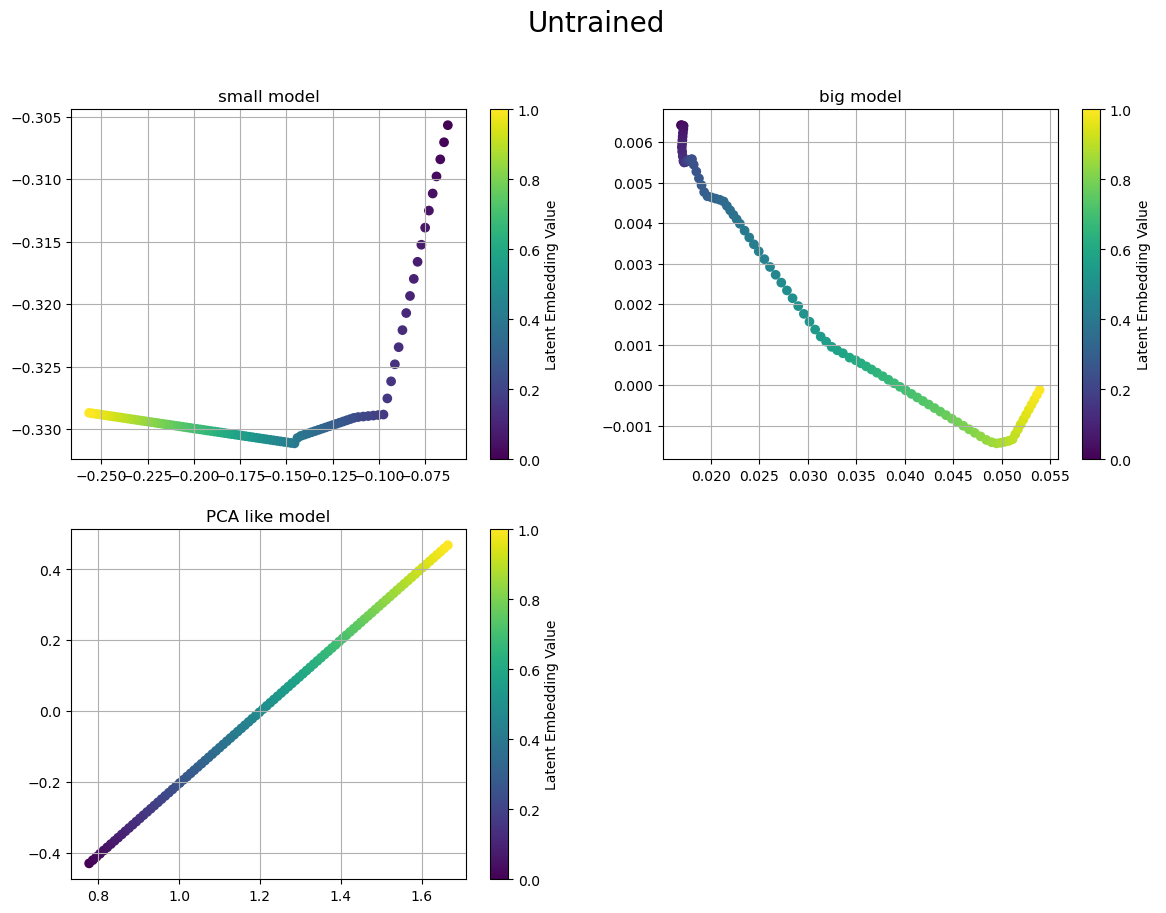

In [31]:
# init untrained models
untrained_autoencoder_small = AutoencoderModule(hidded_channels=hidded_channels_small,latent_dim=1, input_dim=2, activation=nn.ReLU) 
untrained_autoencoder_big = AutoencoderModule(hidded_channels=hidded_channels_big,latent_dim=1, input_dim=2, activation=nn.ReLU ) 
untrained_PCA_autoencoder = AutoencoderModule(hidded_channels=None,PCA=True,latent_dim=1, input_dim=2) 

samples_decoded_untrained_small = untrained_autoencoder_small.autoencoder.decode(latent_space_samples)
samples_decoded_untrained_big = untrained_autoencoder_big.autoencoder.decode(latent_space_samples)
samples_decoded_untrained_PCA = untrained_PCA_autoencoder.autoencoder.decode(latent_space_samples)


fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Adjust figsize for better layout

scatter1 = axes[0,0].scatter(samples_decoded_untrained_small[:, 0].detach().numpy(), samples_decoded_untrained_small[:, 1].detach().numpy(),c=latent_space_samples.detach().numpy(), cmap='viridis')
scatter2 = axes[0,1].scatter(samples_decoded_untrained_big[:, 0].detach().numpy(), samples_decoded_untrained_big[:, 1].detach().numpy(),c=latent_space_samples.detach().numpy(), cmap='viridis')
scatter3 = axes[1,0].scatter(samples_decoded_untrained_PCA[:, 0].detach().numpy(), samples_decoded_untrained_PCA[:, 1].detach().numpy(),c=latent_space_samples.detach().numpy(), cmap='viridis')

fig.colorbar(scatter1, ax=axes[0, 0], label="Latent Embedding Value")
fig.colorbar(scatter2, ax=axes[0, 1], label="Latent Embedding Value")
fig.colorbar(scatter3, ax=axes[1, 0], label="Latent Embedding Value")

axes[0,0].set_title("small model")
axes[0,1].set_title("big model")
axes[1,0].set_title("PCA like model")

axes[0,0].grid(True)
axes[0,1].grid(True)
axes[1,0].grid(True)
fig.suptitle('Untrained',fontsize=20)
# Hide the empty subplot (bottom-right) as we only need 3 plots
axes[1, 1].axis('off')
plt.show()

## (e) and (f) discussion
### (e)
Given enough parameters, the encoder can reconstruct the finite number of points by fitting the intepolation polynimal that fits all the points. This representation howerver is not very useful due to extreme overfitting.

### (f)

The encoder will with high likelyhood converge to a embedding close to the original encoder. But due to inefficiencies during training and the now more and less possible output values (since the decoder is fixed) the result will be less accurate then the original encoder.


## (g)

### my first thought says should be not so hard to do, just init a new model with the hidded_channels_big, train normally. then reinit the encoder. (probably make a funtion in class for this) and then modify (or make new) configure_optimizers function, such that only encoder parameters are updated, something like:


def configure_optimizers(self): 
        # Optimizer for only encoder parameters 
        
        optimizer = torch.optim.Adam(self.autoencoder.encoder.parameters()) 
        return optimizer

### in the class, idk exactly, as new func or modifing the other.
### ah there is also a hint maybe that is better than this crap haha